In [1]:
#Handle general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
import sys

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


structuring_code_path = "../structuring_code/"
sum_path = "../joule_declass_sum/"
raw_path = "../joule_declass_raw/"
joule_cell_id_path =  "../Joule_cell_id.csv"
sys.path.insert(0, structuring_code_path)



In [34]:
#Load functions from modules of interest
from Joule_sum_data_builder import load_sum_obj
from plotting_and_fitting_helpers import get_mean_trend, local_reg_adjust_window

In [3]:
temp_color_dict = {24: "royalblue", 45: "gold", 60: "darkorange", 85: "firebrick"}
#Controls whether the marker is filled or empty
soc_fill_dict = {50: "none", 100: "full"}
cell_type_list=['K2 Energy LFP18650E', 'K2 Energy LFP18650P', 'Panasonic NCR18650B',
                'Panasonic NCR18650GA', 'Sony-Murata US18650VTC6', 'Tenergy 302030',
                'Ultralife 502030', 'Ultralife UBP001']

#tried to group similar types of chemistries together. 
cell_type_marker_dict = {"Panasonic NCR18650GA": "X", 'Panasonic NCR18650B': "P", "K2 Energy LFP18650P": "s", "K2 Energy LFP18650E": "D",
                            'Ultralife UBP001': "^", "Ultralife 502030": "v", "Tenergy 302030": "*", "Sony-Murata US18650VTC6": "o"}

joule_cell_id_df = pd.read_csv(joule_cell_id_path)
joule_cell_id_df_to_use = joule_cell_id_df[joule_cell_id_df["Cell_type"].isin(cell_type_list)]

## Plotting the Variability of Capacity.

In [4]:
#Get the unique testing conditions
testing_cond_cols = ["Cell_type", "SOC", "Temperature"]
unique_testing_cond = joule_cell_id_df_to_use[testing_cond_cols].drop_duplicates()


In [5]:
#Initialize empty dict
condition_dict_interp = {}
#initialize each part with its own values
for cell_type in cell_type_list:
    cell_type_df = unique_testing_cond[unique_testing_cond["Cell_type"]==cell_type]
    condition_dict_interp[cell_type]={}

    for temperature in list(set(cell_type_df["Temperature"])):
        temperature_cell_type_df = cell_type_df[cell_type_df["Temperature"]==temperature]
        condition_dict_interp[cell_type][temperature]={}
        for soc in list(set(temperature_cell_type_df["SOC"])):
            condition_dict_interp[cell_type][temperature][soc]={}

In [7]:
#get mean curves of all unique conditions

cap_metric = "RPT0.2C_2_D_capacity"
res_metric = "Res_SS_2_D"
sum_obj_list = [x for x in os.listdir(sum_path) if x.endswith("json")]

#Loop over all the unique testing conditions
for unique_condition_idx in tqdm(range(len(unique_testing_cond))):
    #get the cell_ids for particular testing conditions of interest
    condition_series = unique_testing_cond.iloc[unique_condition_idx]
    condition_filter = joule_cell_id_df_to_use.eq(condition_series)[condition_series.index].all(axis=1)
    cell_id_list = list(joule_cell_id_df_to_use[condition_filter]["Cell_id"])
    cell_type = condition_series["Cell_type"]
    temperature = condition_series["Temperature"]
    soc = condition_series["SOC"]

    temp_cell_id_dict = {}
    all_times = []

    #first get sum_names of unique files to test
    sum_obj_uniquecond_list = []
    for idx, cell_id in enumerate(cell_id_list):
        sum_name = "{}_sum.json".format(cell_id)
        #If this sum_name is not found in the sum_folder, just skip
        if sum_name not in sum_obj_list:
            continue

        sum_obj_uniquecond_list.append(sum_name)
    
    #get mean trend
    mean_cap_array, std_cap_array, all_times, num_cells_cap = get_mean_trend(sum_obj_uniquecond_list, sum_path,cap_metric, normalize_before_mean=False)
    mean_res_array, std_res_array, all_times, num_cells_res = get_mean_trend(sum_obj_uniquecond_list, sum_path,res_metric, normalize_before_mean=False)

    #add to dict for storage
    condition_dict_interp[cell_type][temperature][soc] = {"mean_cap_array": mean_cap_array, "std_cap_array": std_cap_array, "num_cell_array_cap": num_cells_cap,
                                                        "mean_res_array": mean_res_array, "std_res_array": std_res_array, "num_cell_array_res": num_cells_res,
                                                            "all_time_points": all_times}



100%|██████████| 42/42 [00:03<00:00, 11.04it/s]


In [19]:
#Set plotting parameters
font_size_set = 8

plt.rc('font', size=font_size_set)          # controls default text sizes
plt.rc('axes', titlesize=font_size_set)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_set)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_set)    # legend fontsize
plt.rc('figure', titlesize=font_size_set)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc("lines", lw=1.5)

scatter_size = 5

100%|██████████| 42/42 [00:00<00:00, 3786.94it/s]


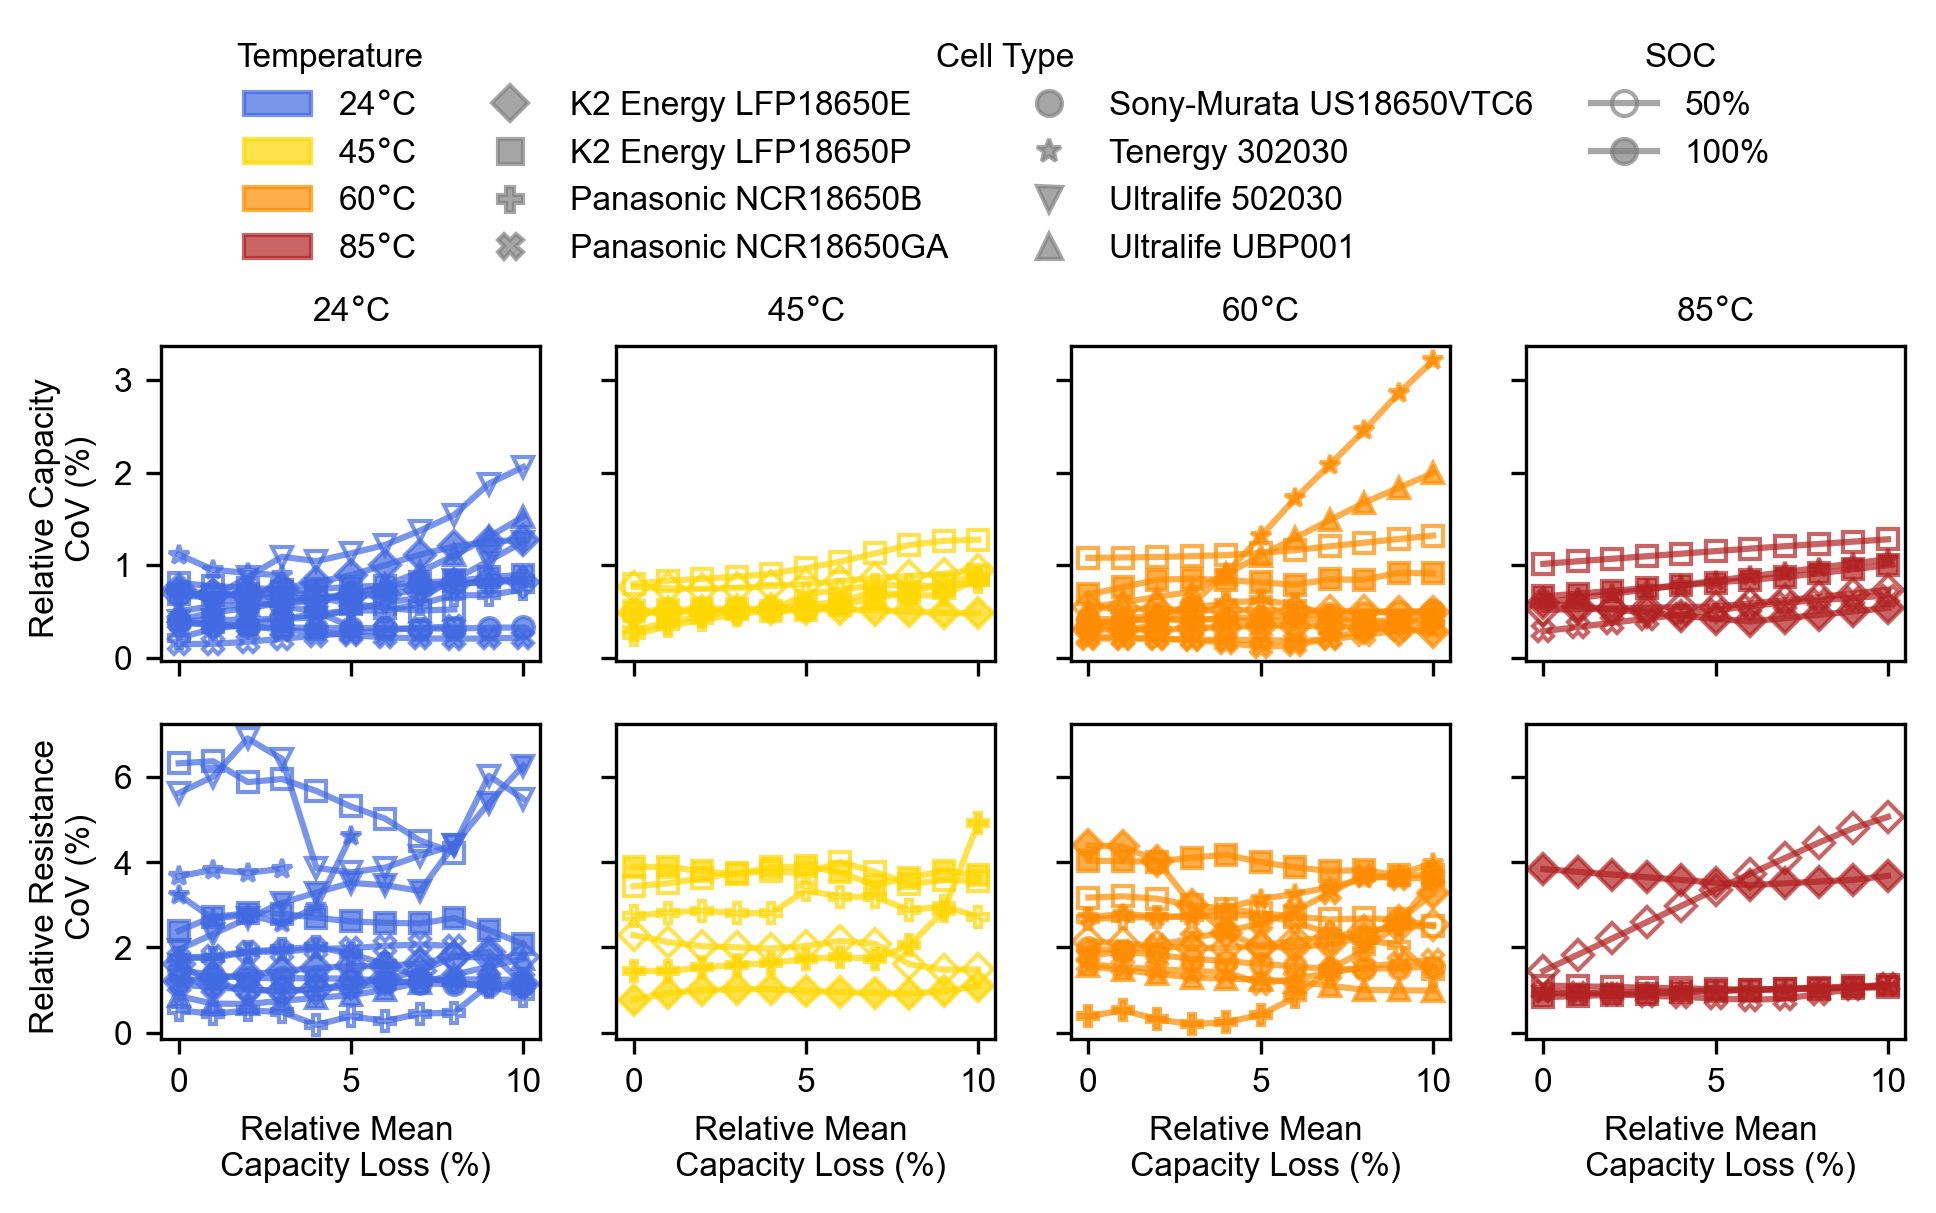

In [32]:
#Now to plot all the ones that we just did, but separate them out

fig,axs = plt.subplots(2,4,figsize=(7.5,3), dpi=300, sharex=True, sharey="row")
eol_cond = 0.9
color_list = ["royalblue", "gold", "darkorange", "firebrick"]
marker_list = ["^", "o"]
soc_list = [50, 100]
soc_fill_style = ["none", "full"]

temp_list = [24, 45, 60, 85]

for unique_condition_idx in tqdm(range(len(unique_testing_cond))):
    #get the testing condition parameters of interest
    condition_series = unique_testing_cond.iloc[unique_condition_idx]
    cell_type = condition_series["Cell_type"]
    temperature = condition_series["Temperature"]
    soc = condition_series["SOC"]
    ax = axs[1, temp_list.index(temperature)]

    plot_kwargs_dict = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color": temp_color_dict[temperature], "alpha":0.7, "markersize":scatter_size}

    #extract arrays from the dictionary
    testing_cond_dict = condition_dict_interp[cell_type][temperature][soc]
    mean_cap_array = testing_cond_dict["mean_cap_array"]
    coeffv_res_array = (testing_cond_dict["std_res_array"]/testing_cond_dict["mean_res_array"])*100
    num_cells_array = testing_cond_dict["num_cell_array_cap"]
    all_time_array = testing_cond_dict["all_time_points"]

    #this means it failed a previous min data required condition
    if len(all_time_array)==0:
        continue


    #If it has reached the EOL interpolate this point
    if (mean_cap_array<=mean_cap_array[0]*0.9).any():

        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        cap_percent_fade_array = np.arange(0, 11, 1)
        cap_fraction_array = np.arange(1,0.89,-.01)
        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        coeffv_to_plot = cap_coeffv_func(cap_fraction_array*mean_cap_array[0])

    #If it has not reached EOL, instead just take the EOT point.
    else:

        #will stop at the 1% capacity point right before the min capacity is reached
        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        min_cap_frac = np.min(mean_cap_array/mean_cap_array[0])
        cap_fraction_array = np.arange(1,min_cap_frac,-.01)
        cap_percent_fade_array = np.arange(0, (1-min_cap_frac)*100, 1)
        coeffv_to_plot = cap_coeffv_func(cap_fraction_array*mean_cap_array[0])

    marker = marker_list[soc_list.index(soc)]
    color = color_list[temp_list.index(temperature)]
    ax.plot(cap_percent_fade_array, coeffv_to_plot, **plot_kwargs_dict)

#Plotting capacity
for unique_condition_idx in tqdm(range(len(unique_testing_cond))):
    #get the testing condition parameters of interest
    condition_series = unique_testing_cond.iloc[unique_condition_idx]
    cell_type = condition_series["Cell_type"]
    temperature = condition_series["Temperature"]
    soc = condition_series["SOC"]
    ax = axs[0, temp_list.index(temperature)]

    plot_kwargs_dict = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color": temp_color_dict[temperature], "alpha":0.7, "markersize":scatter_size}

    #extract arrays from the dictionary
    testing_cond_dict = condition_dict_interp[cell_type][temperature][soc]
    mean_cap_array = testing_cond_dict["mean_cap_array"]
    coeffv_res_array = (testing_cond_dict["std_cap_array"]/testing_cond_dict["mean_cap_array"])*100
    num_cells_array = testing_cond_dict["num_cell_array_cap"]
    all_time_array = testing_cond_dict["all_time_points"]

    #this means it failed a previous min data required condition
    if len(all_time_array)==0:
        continue


    #If it has reached the EOL interpolate this point
    if (mean_cap_array<=mean_cap_array[0]*0.9).any():

        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        cap_percent_fade_array = np.arange(0, 11, 1)
        cap_fraction_array = np.arange(1,0.89,-.01)
        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        coeffv_to_plot = cap_coeffv_func(cap_fraction_array*mean_cap_array[0])

    #If it has not reached EOL, instead just take the EOT point.
    else:

        #will stop at the 1% capacity point right before the min capacity is reached
        cap_coeffv_func = interp1d(mean_cap_array, coeffv_res_array)
        min_cap_frac = np.min(mean_cap_array/mean_cap_array[0])
        cap_fraction_array = np.arange(1,min_cap_frac,-.01)
        cap_percent_fade_array = np.arange(0, (1-min_cap_frac)*100, 1)
        coeffv_to_plot = cap_coeffv_func(cap_fraction_array*mean_cap_array[0])

    marker = marker_list[soc_list.index(soc)]
    color = color_list[temp_list.index(temperature)]
    ax.plot(cap_percent_fade_array, coeffv_to_plot, **plot_kwargs_dict)

cap_ylim = [-0.1, 4]
res_ylim = [-0.1, 7]




axs[1,0].set_xlabel("Relative Mean \n Capacity Loss (%)")
axs[1,1].set_xlabel("Relative Mean \n Capacity Loss (%)")
axs[1,2].set_xlabel("Relative Mean \n Capacity Loss (%)")
axs[1,3].set_xlabel("Relative Mean \n Capacity Loss (%)")

axs[0,0].set_ylabel("Relative Capacity \n CoV (%)")
axs[1,0].set_ylabel("Relative Resistance \n CoV (%)")



axs[0,0].set_title(r'24$\degree$C')
axs[0,1].set_title(r'45$\degree$C')
axs[0,2].set_title(r'60$\degree$C')
axs[0,3].set_title(r'85$\degree$C')





# Add in legend

y_legend_pos = 1.25


cell_type_handles = []
for cell_type in cell_type_list:
    cell_type_handles.append(Line2D([0], [0],label='{}'.format(cell_type),color="gray", alpha=0.7, 
                    fillstyle="full",marker=cell_type_marker_dict[cell_type], linestyle="None"))

fig.legend(handles=cell_type_handles, bbox_to_anchor=(0.5, y_legend_pos), loc='upper center', title="Cell Type", frameon=False, ncols=2)

patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)
temp_handles = [patch_24, patch_45, patch_60, patch_85]
fig.legend(handles=temp_handles, bbox_to_anchor=(0.2, y_legend_pos), loc='upper center', ncol=1, title="Temperature", frameon=False)

line_soc_50 = Line2D([0], [0], label='50%', alpha=0.7, color="gray", marker="o", fillstyle="none")
line_soc_100 = Line2D([0], [0], label='100%', alpha=0.7, color="gray", marker="o", fillstyle="full")
soc_handles = [line_soc_50, line_soc_100]
fig.legend(handles=soc_handles, bbox_to_anchor=(0.8, y_legend_pos), loc='upper center', ncol=1, title= "SOC", frameon=False)



#fig.savefig("../figures/figure7_variability_trend_a.svg", transparent=True, format="svg", bbox_inches='tight')

plt.show()




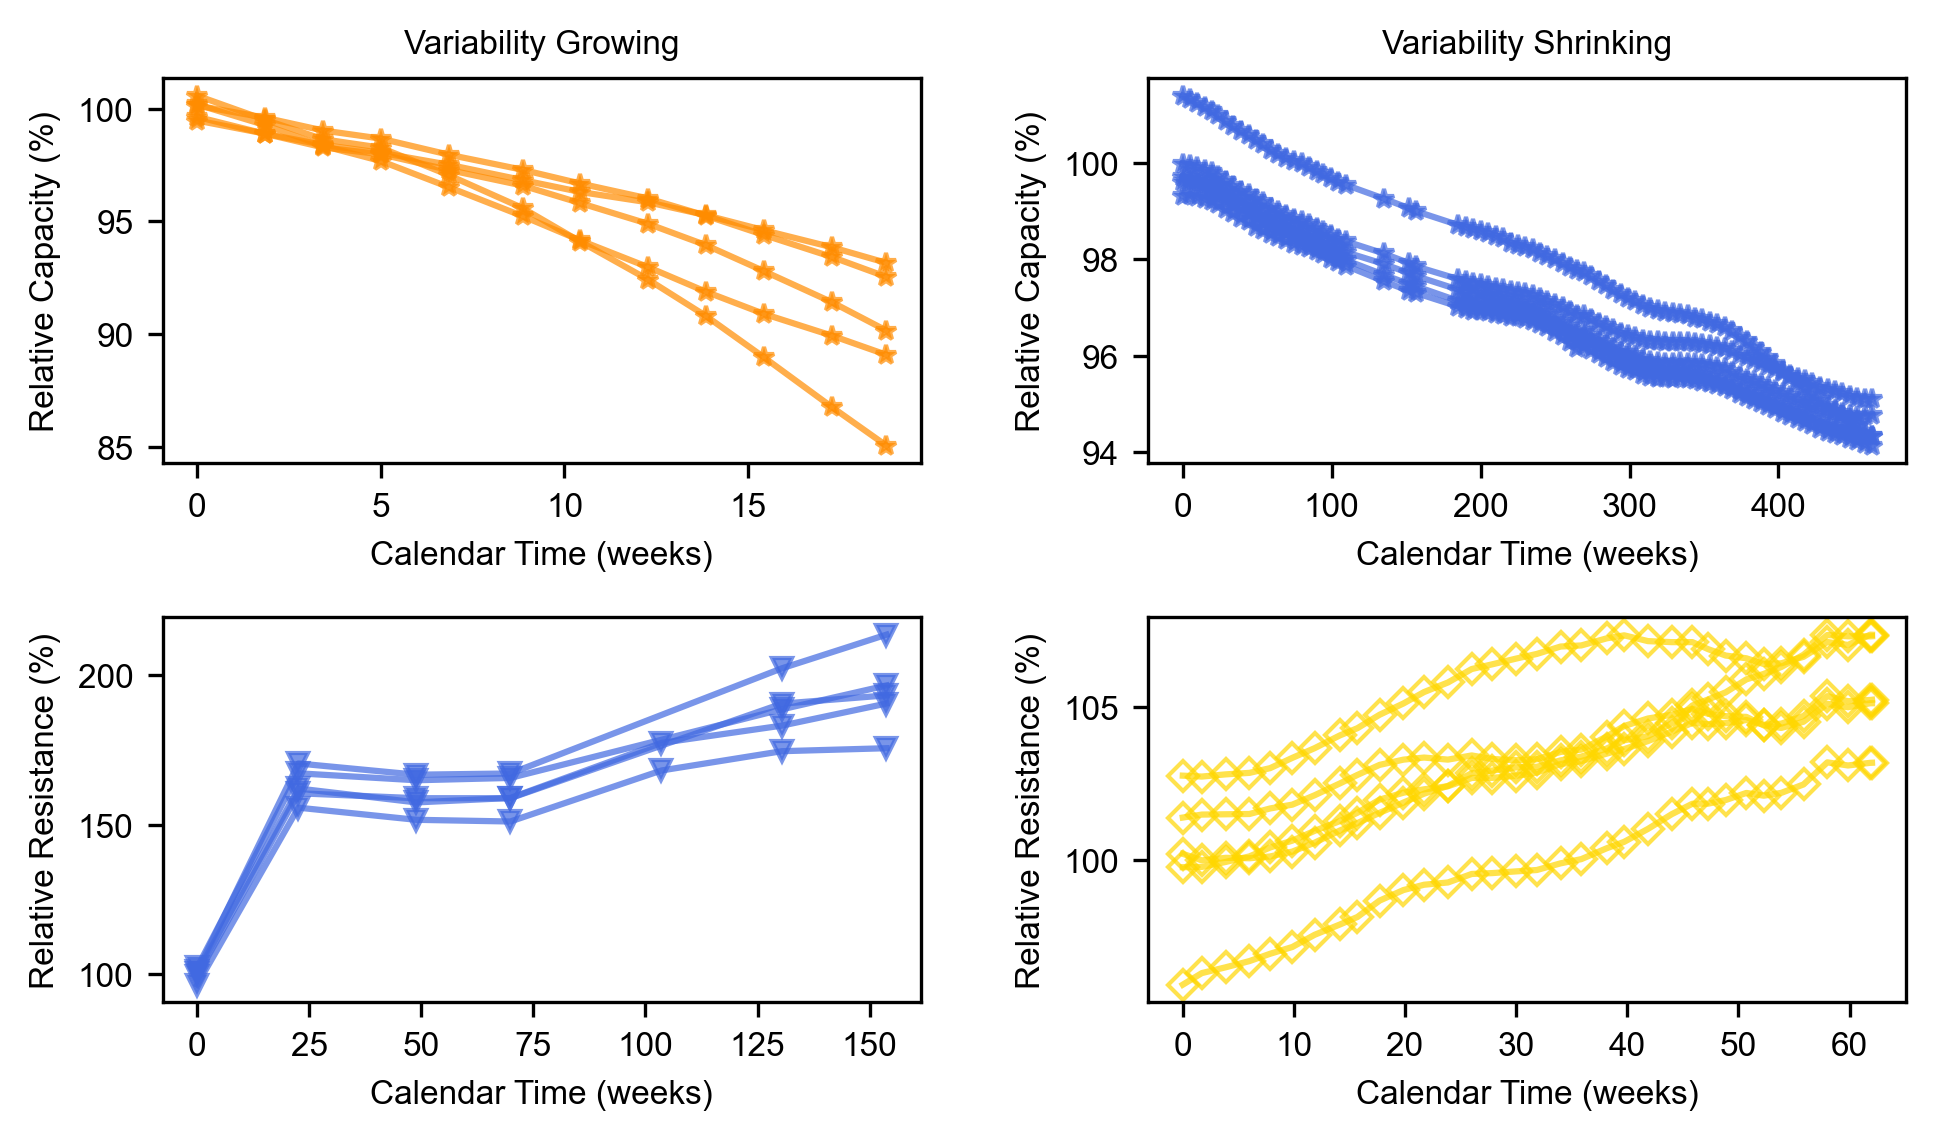

In [36]:
# cell_type = "Ultralife 502030"
# temperature = 24
# soc = 50


fig, axs = plt.subplots(2, 2, figsize=(7.5, 4), dpi=300)
cap_metric = "RPT0.2C_2_D_capacity"
res_metric = "Res_SS_2_D"

cell_type_ex = ["Tenergy 302030", "Tenergy 302030"]
temperature_ex = [60, 24]
soc_ex = [100, 100]


for idx in range(len(cell_type_ex)):
    cell_type = cell_type_ex[idx]
    temperature = temperature_ex[idx]
    soc = soc_ex[idx]

    condition_series = unique_testing_cond[(unique_testing_cond["Cell_type"]==cell_type) & (unique_testing_cond["Temperature"]==temperature) & (unique_testing_cond["SOC"]==soc)].iloc[0]
    condition_filter = joule_cell_id_df_to_use.eq(condition_series)[condition_series.index].all(axis=1)
    cell_id_list = list(joule_cell_id_df_to_use[condition_filter]["Cell_id"])

    testing_cond_dict = condition_dict_interp[cell_type][temperature][soc]
    mean_cap_array = testing_cond_dict["mean_cap_array"]
    coeffv_res_array = (testing_cond_dict["std_res_array"]/testing_cond_dict["mean_res_array"])*100
    num_cells_array = testing_cond_dict["num_cell_array_cap"]
    all_time_array = testing_cond_dict["all_time_points"]



    #If this fails just set eol really long so it doesn't worry about it
    time_mean_func = interp1d((mean_cap_array/mean_cap_array[0])*100, all_time_array)
    try:
        eol_mean_time = time_mean_func(90)
    except:
        eol_mean_time = 100000000

    plot_kwargs_dict = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color": temp_color_dict[temperature], "alpha":0.7, "markersize":scatter_size}



    for cell_id in cell_id_list:
        sum_name = "{}_sum.json".format(cell_id)
        #If this sum_name is not found in the sum_folder, just skip
        if sum_name not in sum_obj_list:
            continue
        #Load in the sum_obj and data
        sum_obj=load_sum_obj(file_path=sum_path+sum_name)
        df = sum_obj.summary_data
        cap_points = np.array(df[cap_metric])
        time_points = np.array(df["Calendar_DateTime(days)"])/7 #weeks

        #If time points are less than 4 we will just skip
        if(len(time_points))<4:
            continue

        
        #rel_smoothed_metric_points = lowess_deg2_adjust_window(time_points, rel_metric_points,  min_data_points=0, nominal_window_size=15, force_start_value=True)
        smoothed_cap_points = local_reg_adjust_window(time_points, cap_points, deg=2, throw_min_error=False, force_start_value=True)
        smoothed_norm_cap_points = (smoothed_cap_points/mean_cap_array[0])*100

        #If eol reached interp eol point
        if time_points[-1]>eol_mean_time:
            cap_to_plot = smoothed_norm_cap_points[time_points<eol_mean_time]
            time_to_plot = time_points[time_points<eol_mean_time]
            #add the last point
            cap_fade_func = interp1d(time_points, smoothed_norm_cap_points)
            eol_cap = cap_fade_func(eol_mean_time)
            cap_to_plot = np.append(cap_to_plot, eol_cap)
            time_to_plot = np.append(time_to_plot, eol_mean_time)


        else:
            cap_to_plot = smoothed_norm_cap_points
            time_to_plot = time_points


        # #interpolate so that we can get all time points standardized
        # smooth_cap_fun = interp1d(time_points, smoothed_cap_points, bounds_error=False, fill_value=np.nan)


        axs[0, idx].plot(time_to_plot, cap_to_plot, **plot_kwargs_dict)
    axs[0, idx].set_ylabel("Relative Capacity (%)")
    axs[0, idx].set_xlabel("Calendar Time (weeks)")
            

######## This is for the second row the resistance ones

cell_type_ex = ["Ultralife 502030", "K2 Energy LFP18650E"]
temperature_ex = [24, 45]
soc_ex = [100, 50]

for idx in range(len(cell_type_ex)):
    cell_type = cell_type_ex[idx]
    temperature = temperature_ex[idx]
    soc = soc_ex[idx]

    condition_series = unique_testing_cond[(unique_testing_cond["Cell_type"]==cell_type) & (unique_testing_cond["Temperature"]==temperature) & (unique_testing_cond["SOC"]==soc)].iloc[0]
    condition_filter = joule_cell_id_df_to_use.eq(condition_series)[condition_series.index].all(axis=1)
    cell_id_list = list(joule_cell_id_df_to_use[condition_filter]["Cell_id"])

    testing_cond_dict = condition_dict_interp[cell_type][temperature][soc]
    mean_cap_array = testing_cond_dict["mean_cap_array"]
    mean_res_array = testing_cond_dict["mean_res_array"]
    coeffv_res_array = (testing_cond_dict["std_res_array"]/testing_cond_dict["mean_res_array"])*100
    num_cells_array = testing_cond_dict["num_cell_array_cap"]
    all_time_array = testing_cond_dict["all_time_points"]



    #If this fails just set eol really long so it doesn't worry about it
    time_mean_func = interp1d((mean_cap_array/mean_cap_array[0])*100, all_time_array)
    try:
        eol_mean_time = time_mean_func(90)
    except:
        eol_mean_time = 100000000

    plot_kwargs_dict = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color": temp_color_dict[temperature], "alpha":0.7, "markersize":scatter_size}



    for cell_id in cell_id_list:
        sum_name = "{}_sum.json".format(cell_id)
        #If this sum_name is not found in the sum_folder, just skip
        if sum_name not in sum_obj_list:
            continue
        #Load in the sum_obj and data
        sum_obj=load_sum_obj(file_path=sum_path+sum_name)
        df = sum_obj.summary_data

        res_points = np.array(df[res_metric])
        time_points = np.array(df["Calendar_DateTime(days)"])/7

        #If time points are less than 4 we will just skip
        if(len(time_points))<4:
            continue

        smoothed_res_points = local_reg_adjust_window(time_points, res_points, deg=2, throw_min_error=False, force_start_value=True)
        #interpolate so that we can get all time points standardized
        smooth_res_fun = interp1d(time_points, smoothed_res_points, bounds_error=False, fill_value=np.nan)
        smoothed_norm_res_points = (smoothed_res_points/mean_res_array[0])*100

        #If eol reached interp eol point
        if time_points[-1]>eol_mean_time:
            res_to_plot = smoothed_norm_res_points[time_points<eol_mean_time]
            time_to_plot = time_points[time_points<eol_mean_time]
            #add the last point
            res_growth_func = interp1d(time_points, smoothed_norm_res_points)
            eol_res = res_growth_func(eol_mean_time)
            res_to_plot = np.append(res_to_plot, eol_res)
            time_to_plot = np.append(time_to_plot, eol_mean_time)


        else:
            res_to_plot = smoothed_norm_res_points
            time_to_plot = time_points


        # #interpolate so that we can get all time points standardized
        # smooth_cap_fun = interp1d(time_points, smoothed_cap_points, bounds_error=False, fill_value=np.nan)

        axs[1,idx].plot(time_to_plot, res_to_plot, **plot_kwargs_dict)
    axs[1, idx].set_ylabel("Relative Resistance (%)")
    axs[1, idx].set_xlabel("Calendar Time (weeks)")


axs[0,0].set_title("Variability Growing")
axs[0,1].set_title("Variability Shrinking")

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)

# fig.savefig("../figures/figure7_variability_trend_b.svg", transparent=True, format="svg", bbox_inches='tight')


